# CW

**Power Systems Planning Coursework
Hilmi Abdul Samat & Hussein**

## Building the problem with Julia + JuMP

**1. Load packages**

First, let's load the Julia packages we'll need to work with here.

In [688]:
# Uncomment this line if you need to install these packages:
# import Pkg; Pkg.add("JuMP"); Pkg.add("HiGHS"); Pkg.add("DataFrames"); Pkg.add("CSV"); Pkg.add("Statistics")
using JuMP, HiGHS, Plots, DataFrames, CSV, Statistics

**2. Load parameters (data)**

In [689]:
# Fixed costs [$/MW]
Fixed_Cost_Solar = 1481439   # Fixed cost for solar panels
Fixed_Cost_stor_node1 = 2160430   # Storage fixed cost at Node 1 [$/MWh]
Fixed_Cost_stor_node2 = 2160430   # Storage fixed cost at Node 2 [$/MWh]

# Variable O&M costs [$/MWh]
Var_OM_Solar = 1.6*1e-2*1e3*1.1           # Variable O&M cost for solar panels

# Value of Lost Load [$/MWh]
VoLL_node1 = 16220          # VoLL at Node 1 - Demand class : Residential 174.50e2 
VoLL_node2 = VoLL_node1*3   # VoLL at Node 2 - Demand class : Agriculture  3 times bigger 

# User-defined transmission capacity (MW)
trans_cap = 0.000  # Example value, replace with your desired capacity

# Transmission line parameters
distance = 10.0  # Distance between nodes, 10km
voltage = 33.0    # Transmission voltage in kV
power_factor = 0.8 

# Transmission line costs [$/km-kW] 15
cost_perkm_perkW = 15

Fixed_Cost_Trans = distance*cost_perkm_perkW*(trans_cap*1000) 

R = 0.1828 # Ohm/km; 0.1–0.2 Ω/km (standard for ACSR conductors).
Total_R = R*distance # Ohm

Current = trans_cap*1e6/(sqrt(3)*voltage*1e3*cos(power_factor)) #Amps
Loss = 3*Total_R*Current^2 #W

# Add 1-2% to take into account AC losses due to skin effect etc
loss_fraction = trans_cap > 0 ? (Loss/(trans_cap*1e6))+0.015 : 0.0

0.0

In [690]:
# Load storage parameters
storage_node1 = CSV.File("Storage_Node1.csv") |> DataFrame  # Pmax (MW), SOCmax (MWh), efficiencies
storage_node2 = CSV.File("Storage_Node2.csv") |> DataFrame

1×5 DataFrame
 Row │ Technology  Pmax     SOCmax   charge_eff  discharge_eff 
     │ String7     Float64  Float64  Float64     Float64       
─────┼─────────────────────────────────────────────────────────
   1 │ BESS            0.5      0.4         0.9            0.9

In [691]:
# Load demand profiles [MW]
demand_node1 = (CSV.File("demand_node1.csv") |> DataFrame)
demand_node2 = (CSV.File("demand_node2.csv") |> DataFrame)

8760×1 DataFrame
  Row │ demand MW  
      │ Float64    
──────┼────────────
    1 │ 0.00462407
    2 │ 0.00453933
    3 │ 0.00474802
    4 │ 0.00482084
    5 │ 0.00583467
    6 │ 0.00639813
    7 │ 0.00853228
    8 │ 0.00971023
    9 │ 0.0165976
   10 │ 0.017804
   11 │ 0.0193269
  ⋮   │     ⋮
 8751 │ 0.0140063
 8752 │ 0.0127232
 8753 │ 0.0226677
 8754 │ 0.0225022
 8755 │ 0.0220228
 8756 │ 0.0103813
 8757 │ 0.00811726
 8758 │ 0.00660853
 8759 │ 0.00557097
 8760 │ 0.00483517
  8739 rows omitted

In [692]:
# Load solar capacity factors (time-series)
cf_solar_node1 = CSV.File("RES_profilesnode1.csv") |> DataFrame  # Solar CF for Node 1
cf_solar_node2 = CSV.File("RES_profilesnode2.csv") |> DataFrame  # Solar CF for Node 2

8760×1 DataFrame
  Row │ irradiance 
      │ Float64    
──────┼────────────
    1 │      0.0
    2 │      0.0
    3 │      0.0
    4 │      0.0
    5 │      0.074
    6 │      0.264
    7 │      0.469
    8 │      0.658
    9 │      0.771
   10 │      0.787
   11 │      0.761
  ⋮   │     ⋮
 8751 │      0.238
 8752 │      0.061
 8753 │      0.0
 8754 │      0.0
 8755 │      0.0
 8756 │      0.0
 8757 │      0.0
 8758 │      0.0
 8759 │      0.0
 8760 │      0.0
  8739 rows omitted

**3. Define sets**

Now let's define the sets we are going to use to index our variables. The **sets** are:

- $STOR$, the set of energy storage systems (pump hydro energy storage and battery energy storage systems): \[PHES, BESS\]
- $T$, the set of hours in a day/month/year: \[1,...,24,...,168,...,8760\]. 

In [693]:
nodes = [1, 2]
T = 1:size(demand_node1, 1)  # Time periods based on demand data
STOR = storage_node1.Technology  # Storage technologies

1-element PooledArrays.PooledVector{String7, UInt32, Vector{UInt32}}:
 "BESS"

**4. Define the model and specify solver**

In [694]:
model = Model(HiGHS.Optimizer) # using the HiGHS open source solver

A JuMP Model
├ solver: HiGHS
├ objective_sense: FEASIBILITY_SENSE
├ num_variables: 0
├ num_constraints: 0
└ Names registered in the model: none

**5. Define variables**

Next, define decision variables:

\begin{align*}
    \text{solar_cap}_i &\geq 0 \quad \forall i \in \text{nodes} \\
    \text{solar_gen}_{i,t} &\geq 0 \quad \forall i \in \text{nodes}, t \in T
\end{align*}

\begin{align*}
0 \leq \text{storage_size}_{i,s} &\leq \text{SOCmax}_s 
   \quad \forall i \in \text{nodes},\, s \in \text{STOR} \\[1ex]
0 \leq \text{charge}_{i,s,t} &\leq \text{Pmax}_s 
   \quad \forall i \in \text{nodes},\, s \in \text{STOR},\, t \in T \\[1ex]
0 \leq \text{discharge}_{i,s,t} &\leq \text{Pmax}_s 
   \quad \forall i \in \text{nodes},\, s \in \text{STOR},\, t \in T \\[1ex]
\text{soc}_{i,s,t} &\geq 0 
   \quad \forall i \in \text{nodes},\, s \in \text{STOR},\, t \in T
\end{align*}

\begin{align*}
\text{nse}_{i,t} &\geq 0 
   \quad \forall i \in \text{nodes},\, t \in T \\[1ex]
0 \leq \text{flow_pos}_t &\leq \text{trans_cap} 
   \quad \forall t \in T \\[1ex]
0 \leq \text{flow_neg}_t &\leq \text{trans_cap} 
   \quad \forall t \in T
\end{align*}

In [695]:
# Define solar_cap first
@variable(model, 0 <= solar_cap[i in nodes])

# Define solar_gen without bounds
@variable(model, 0 <= solar_gen[i in nodes, t in T])

# Define storage_size with correct DataFrame indexing
#@variable(model, 0 <= storage_size[i in nodes, s in STOR] <= filter(row -> row.Technology == s, storage_node1).SOCmax[1])
@variable(model, 0 <= storage_size[i in nodes, s in STOR])

# Define charge and discharge with correct DataFrame indexing
@variable(model, 0 <= charge[i in nodes, s in STOR, t in T] <= filter(row -> row.Technology == s, storage_node1).Pmax[1])
@variable(model, 0 <= discharge[i in nodes, s in STOR, t in T] <= filter(row -> row.Technology == s, storage_node1).Pmax[1])

@variable(model, 0 <= soc[i in nodes, s in STOR, t in T])
@variable(model, 0 <= nse[i in nodes, t in T])
@variable(model, 0 <= flow_pos[t in T] <= trans_cap)
@variable(model, 0 <= flow_neg[t in T] <= trans_cap)

1-dimensional DenseAxisArray{VariableRef,1,...} with index sets:
    Dimension 1, 1:8760
And data, a 8760-element Vector{VariableRef}:
 flow_neg[1]
 flow_neg[2]
 flow_neg[3]
 flow_neg[4]
 flow_neg[5]
 flow_neg[6]
 flow_neg[7]
 flow_neg[8]
 flow_neg[9]
 flow_neg[10]
 flow_neg[11]
 flow_neg[12]
 flow_neg[13]
 ⋮
 flow_neg[8749]
 flow_neg[8750]
 flow_neg[8751]
 flow_neg[8752]
 flow_neg[8753]
 flow_neg[8754]
 flow_neg[8755]
 flow_neg[8756]
 flow_neg[8757]
 flow_neg[8758]
 flow_neg[8759]
 flow_neg[8760]

**6. Define constraints**

Set up our constraints:

\begin{multline*}
\text{solar_gen}_{1,t} + \sum_{s \in \text{STOR}} \Bigl( \text{discharge}_{1,s,t} - \text{charge}_{1,s,t} \Bigr)
+ \text{flow_neg}_t \cdot (1 - \text{loss_fraction}) - \text{flow_pos}_t
+ \text{nse}_{1,t} = \text{demand_node1}_{t,1} \quad \forall t \in T
\end{multline*}

\begin{multline*}
\text{solar_gen}_{2,t} + \sum_{s \in \text{STOR}} \Bigl( \text{discharge}_{2,s,t} - \text{charge}_{2,s,t} \Bigr)
+ \text{flow_pos}_t \cdot (1 - \text{loss_fraction}) - \text{flow_neg}_t 
+ \text{nse}_{2,t} = \text{demand_node2}_{t,1} \quad \forall t \in T
\end{multline*}

\begin{align*}
    \text{solar_gen}_{i,t} \leq \text{solar_cap}_i \cdot \begin{cases}
    \text{cf_solar_node1}_{t,1} & \text{if } i = 1 \\
    \text{cf_solar_node2}_{t,1} & \text{if } i = 2
    \end{cases} \quad \forall i \in \text{nodes}, t \in T
\end{align*}

\begin{aligned}
\textbf{Storage Dynamics:} \quad
& \text{soc}_{i,s,t} = \text{soc}_{i,s,t-1} 
   + \text{charge}_{i,s,t} \cdot \eta^{\text{ch}}_{s} 
   - \frac{\text{discharge}_{i,s,t}}{\eta^{\text{dis}}_{s}}, \\
& \quad \forall\, i \in \text{nodes},\; s \in \text{STOR},\; t = 2,\ldots,T, \\[1ex]
\textbf{Initial SOC:} \quad
& \text{soc}_{i,s,1} = 0.5 \cdot \text{storage_size}_{i,s}, 
   \quad \forall\, i \in \text{nodes},\; s \in \text{STOR}, \\[1ex]
\textbf{Final SOC:} \quad
& \text{soc}_{i,s,T} = 0.5 \cdot \text{storage_size}_{i,s}, 
   \quad \forall\, i \in \text{nodes},\; s \in \text{STOR}, \\[1ex]
\textbf{SOC Upper Bound:} \quad
& \text{soc}_{i,s,t} \le \text{storage_size}_{i,s}, 
   \quad \forall\, i \in \text{nodes},\; s \in \text{STOR},\; t \in T.
\end{aligned}

In [696]:
# ENERGY BALANCE WITH LOSSES
# ========================
@constraint(model, [t in T],
    solar_gen[1,t] + sum(discharge[1,s,t] - charge[1,s,t] for s in STOR) +
    flow_neg[t] * (1 - loss_fraction) - flow_pos[t] + nse[1,t] == demand_node1[t,1]
)

@constraint(model, [t in T],
    solar_gen[2,t] + sum(discharge[2,s,t] - charge[2,s,t] for s in STOR) +
    flow_pos[t] * (1 - loss_fraction) - flow_neg[t] + nse[2,t] == demand_node2[t,1]
)

# Add constraints to enforce the relationship
@constraint(model, [i in nodes, t in T],
    solar_gen[i,t] <= solar_cap[i] * (i == 1 ? cf_solar_node1[t,1] : cf_solar_node2[t,1])
)

# Storage dynamics
@constraint(model, [i in nodes, s in STOR, t in T[2:end]],
    soc[i,s,t] == soc[i,s,t-1] + 
    charge[i,s,t] * storage_node1[storage_node1.Technology.==s, :charge_eff][1] -
    discharge[i,s,t] / storage_node1[storage_node1.Technology.==s, :discharge_eff][1]
)

# Initial/Final SOC
@constraint(model, [i in nodes, s in STOR],
    soc[i,s,1] == 0.5 * storage_size[i,s]
)
@constraint(model, [i in nodes, s in STOR],
    soc[i,s,end] == 0.5 * storage_size[i,s]
)

@constraint(model, [i in nodes, s in STOR, t in T],
    soc[i,s,t] <= storage_size[i,s]
)

# TRANSMISSION CAPACITY LIMITS
# ========================
@constraint(model, [t in T], flow_pos[t] <= trans_cap)
@constraint(model, [t in T], flow_neg[t] <= trans_cap)

1-dimensional DenseAxisArray{ConstraintRef{Model, MathOptInterface.ConstraintIndex{MathOptInterface.ScalarAffineFunction{Float64}, MathOptInterface.LessThan{Float64}}, ScalarShape},1,...} with index sets:
    Dimension 1, 1:8760
And data, a 8760-element Vector{ConstraintRef{Model, MathOptInterface.ConstraintIndex{MathOptInterface.ScalarAffineFunction{Float64}, MathOptInterface.LessThan{Float64}}, ScalarShape}}:
 flow_neg[1] <= 0
 flow_neg[2] <= 0
 flow_neg[3] <= 0
 flow_neg[4] <= 0
 flow_neg[5] <= 0
 flow_neg[6] <= 0
 flow_neg[7] <= 0
 flow_neg[8] <= 0
 flow_neg[9] <= 0
 flow_neg[10] <= 0
 flow_neg[11] <= 0
 flow_neg[12] <= 0
 flow_neg[13] <= 0
 ⋮
 flow_neg[8749] <= 0
 flow_neg[8750] <= 0
 flow_neg[8751] <= 0
 flow_neg[8752] <= 0
 flow_neg[8753] <= 0
 flow_neg[8754] <= 0
 flow_neg[8755] <= 0
 flow_neg[8756] <= 0
 flow_neg[8757] <= 0
 flow_neg[8758] <= 0
 flow_neg[8759] <= 0
 flow_neg[8760] <= 0

**7. Define objective function**

\begin{multline*}
\min \quad 
\underbrace{\sum_{i \in \text{nodes}} \text{Fixed_Cost_Solar} \cdot \text{solar_cap}_i}_{\text{Fixed solar capacity cost}} 
+ \underbrace{\sum_{i \in \text{nodes}} \sum_{t \in T} \text{Var_OM_Solar} \cdot \text{solar_gen}_{i,t}}_{\text{Variable solar generation cost}} 
+ \underbrace{\sum_{i \in \{1,2\}} \sum_{s \in \text{STOR}} \text{Fixed_Cost_stor}_{i} \cdot \text{storage_size}_{i,s}}_{\text{Battery capital cost}} 
+ \underbrace{\text{Fixed_Cost_Trans} }_{\text{Transmission cost}} 
+ \underbrace{\sum_{t \in T} \Bigl( \text{VoLL_node1} \cdot \text{nse}_{1,t} + \text{VoLL_node2} \cdot \text{nse}_{2,t} \Bigr)}_{\text{Non-served energy cost}} 
\end{multline*}

In [697]:
# Define objective function
@objective(model, Min,
    sum(Fixed_Cost_Solar * solar_cap[i] for i in nodes) +  # Fixed cost (capacity)
    sum(Var_OM_Solar * solar_gen[i,t] for i in nodes, t in T) +  # Variable cost (production)
    sum(Fixed_Cost_stor_node1 * storage_size[1,s] for s in STOR) +  # Storage cost (Node 1)
    sum(Fixed_Cost_stor_node2 * storage_size[2,s] for s in STOR) +  # Storage cost (Node 2)
    Fixed_Cost_Trans +  # Transmission cost
    sum(VoLL_node1 * nse[1,t] + VoLL_node2 * nse[2,t] for t in T)  # Non-served energy cost
)

1481439 solar_cap[1] + 1481439 solar_cap[2] + 17.6 solar_gen[1,1] + 17.6 solar_gen[1,2] + 17.6 solar_gen[1,3] + 17.6 solar_gen[1,4] + 17.6 solar_gen[1,5] + 17.6 solar_gen[1,6] + 17.6 solar_gen[1,7] + 17.6 solar_gen[1,8] + 17.6 solar_gen[1,9] + 17.6 solar_gen[1,10] + 17.6 solar_gen[1,11] + 17.6 solar_gen[1,12] + 17.6 solar_gen[1,13] + 17.6 solar_gen[1,14] + 17.6 solar_gen[1,15] + 17.6 solar_gen[1,16] + 17.6 solar_gen[1,17] + 17.6 solar_gen[1,18] + 17.6 solar_gen[1,19] + 17.6 solar_gen[1,20] + 17.6 solar_gen[1,21] + 17.6 solar_gen[1,22] + 17.6 solar_gen[1,23] + 17.6 solar_gen[1,24] + 17.6 solar_gen[1,25] + 17.6 solar_gen[1,26] + 17.6 solar_gen[1,27] + 17.6 solar_gen[1,28] + [[...34984 terms omitted...]] + 16220 nse[1,8746] + 48660 nse[2,8746] + 16220 nse[1,8747] + 48660 nse[2,8747] + 16220 nse[1,8748] + 48660 nse[2,8748] + 16220 nse[1,8749] + 48660 nse[2,8749] + 16220 nse[1,8750] + 48660 nse[2,8750] + 16220 nse[1,8751] + 48660 nse[2,8751] + 16220 nse[1,8752] + 48660 nse[2,8752] + 16220 n

**8. Solve the model and extract results**

In [698]:
# Solve the model
optimize!(model)

Running HiGHS 1.8.1 (git hash: 4a7f24ac6): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [1e-02, 1e+00]
  Cost   [2e+01, 2e+06]
  Bound  [5e-01, 5e-01]
  RHS    [3e-03, 8e-02]
Presolving model
61314 rows, 78840 cols, 183944 nonzeros  0s
61312 rows, 78834 cols, 183938 nonzeros  0s
Presolve : Reductions: rows 61312(-26290); columns 78834(-26290); elements 183938(-70102)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Pr: 17518(249.092) 0s
      53458     1.7830792385e+06 Pr: 0(0); Du: 0(1.21048e-10) 3s
Solving the original LP from the solution after postsolve
Model status        : Optimal
Simplex   iterations: 53458
Objective value     :  1.7830792385e+06
Relative P-D gap    :  3.3297350365e-14
HiGHS run time      :          3.44


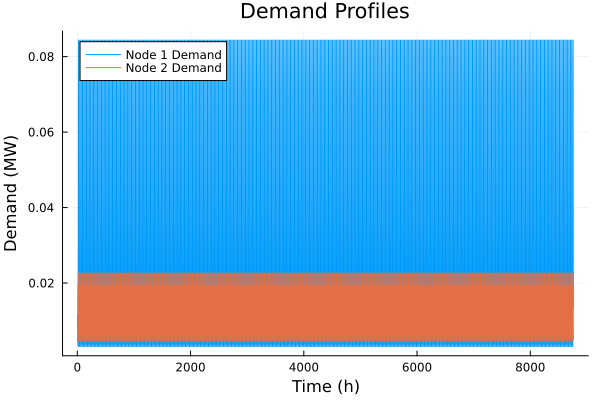

In [699]:
# 1. Plot Demand Data
# ========================
plot(T, demand_node1[:, 1], label="Node 1 Demand", xlabel="Time (h)", ylabel="Demand (MW)", title="Demand Profiles")
plot!(T, demand_node2[:, 1], label="Node 2 Demand")

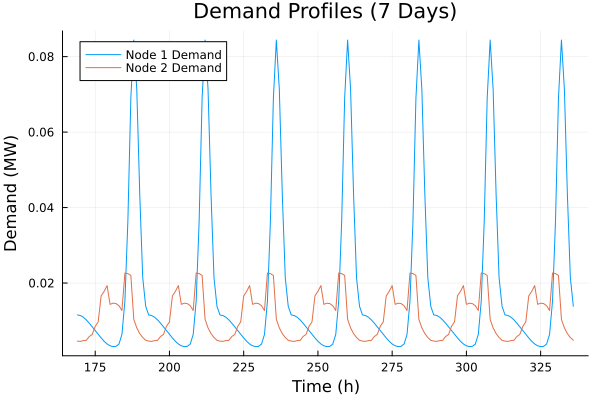

In [700]:
# Define the 7-day period (e.g., week 2)
start_day = 2  # Start from week 2 (you can change this to any week number)
start_hour = (start_day - 1) * 168 + 1  # Start hour index (168 hours = 7 days)
end_hour = start_day * 168  # End hour index
T_7days = start_hour:end_hour  # Time range for the 7-day period

# --- 1. Plot Demand Data for 7 Days ---
demand_node1_7days = demand_node1[T_7days, 1]
demand_node2_7days = demand_node2[T_7days, 1]

plot(T_7days, demand_node1_7days, label="Node 1 Demand", xlabel="Time (h)", ylabel="Demand (MW)", title="Demand Profiles (7 Days)")
plot!(T_7days, demand_node2_7days, label="Node 2 Demand")

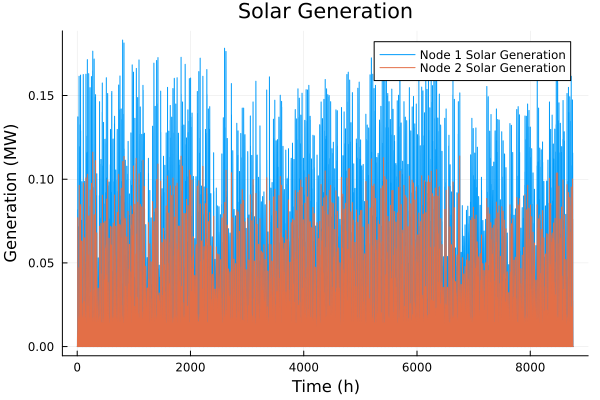

In [701]:
# 2. Plot Production Generation Data
# ========================
# Convert DenseAxisArray to a standard array
solar_gen_values = Array(value.(solar_gen))

# Plot solar generation for Node 1 and Node 2
plot(1:length(T), solar_gen_values[1, :], label="Node 1 Solar Generation", xlabel="Time (h)", ylabel="Generation (MW)", title="Solar Generation")
plot!(1:length(T), solar_gen_values[2, :], label="Node 2 Solar Generation")


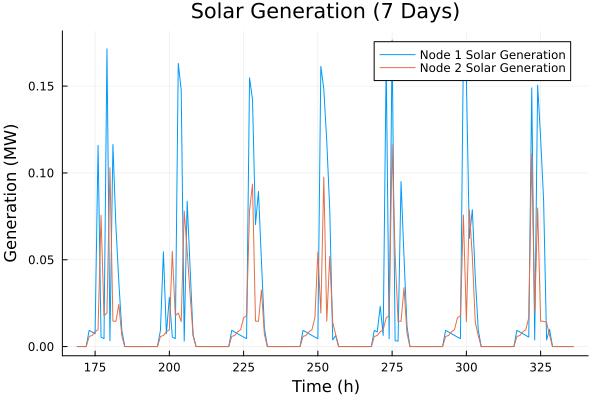

In [702]:
# --- 2. Plot Solar Generation for 7 Days ---
solar_gen_values = Array(value.(solar_gen))
solar_gen_node1_7days = solar_gen_values[1, T_7days]
solar_gen_node2_7days = solar_gen_values[2, T_7days]

plot(T_7days, solar_gen_node1_7days, label="Node 1 Solar Generation", xlabel="Time (h)", ylabel="Generation (MW)", title="Solar Generation (7 Days)")
plot!(T_7days, solar_gen_node2_7days, label="Node 2 Solar Generation")

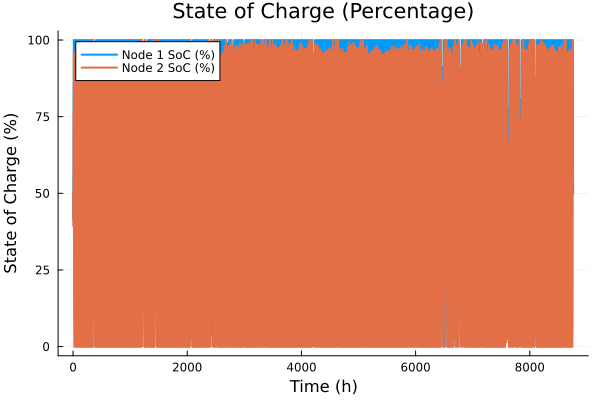

In [703]:
# --- 1. Plot State of Charge (SoC) in Percentage ---

stor_type = STOR[1]

# We convert the SoC (in MWh) to a percentage of the installed storage size.
soc_node1_pct = [100 * value(soc[1, stor_type, t]) / value(storage_size[1, stor_type]) for t in T]
soc_node2_pct = [100 * value(soc[2, stor_type, t]) / value(storage_size[2, stor_type]) for t in T]

plot(T, soc_node1_pct,
     label="Node 1 SoC (%)",
     xlabel="Time (h)",
     ylabel="State of Charge (%)",
     title="State of Charge (Percentage)",
     lw=2)
plot!(T, soc_node2_pct, label="Node 2 SoC (%)", lw=2)

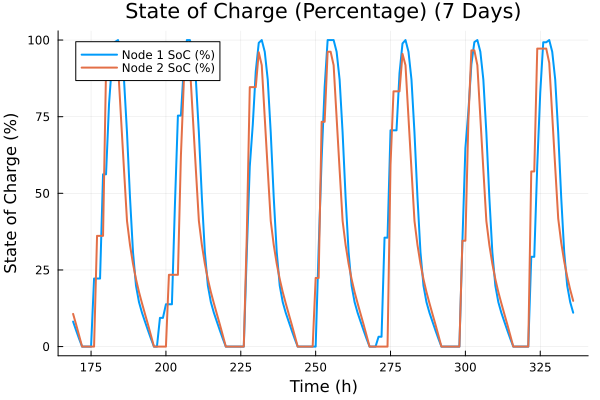

In [704]:
# --- 3. Plot State of Charge (SoC) in Percentage for 7 Days ---
stor_type = STOR[1]

# Convert SoC (in MWh) to a percentage of the installed storage size.
soc_node1_pct = [100 * value(soc[1, stor_type, t]) / value(storage_size[1, stor_type]) for t in T_7days]
soc_node2_pct = [100 * value(soc[2, stor_type, t]) / value(storage_size[2, stor_type]) for t in T_7days]

plot(T_7days, soc_node1_pct,
     label="Node 1 SoC (%)",
     xlabel="Time (h)",
     ylabel="State of Charge (%)",
     title="State of Charge (Percentage) (7 Days)",
     lw=2)
plot!(T_7days, soc_node2_pct, label="Node 2 SoC (%)", lw=2)

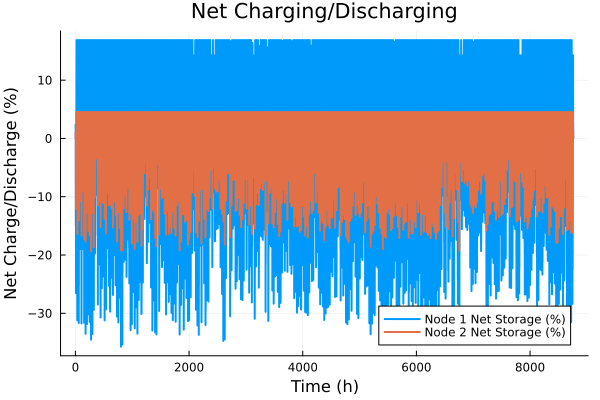

In [705]:
# --- 2. Plot Charging/Discharging (Centered at 0) in Percentage ---

stor_type = STOR[1]

# First, extract the maximum charge/discharge power (P_max) for the chosen storage technology.
# Note: The model sets the upper bound of 'charge' and 'discharge' using the Pmax from the data.
pmax = filter(row -> row.Technology == stor_type, storage_node1).Pmax[1]

# Calculate net storage injection as (discharge - charge) and then express it as a percentage of P_max.
net_storage_node1_pct = [100 * (value(discharge[1, stor_type, t]) - value(charge[1, stor_type, t])) / pmax for t in T]
net_storage_node2_pct = [100 * (value(discharge[2, stor_type, t]) - value(charge[2, stor_type, t])) / pmax for t in T]

plot(T, net_storage_node1_pct,
     label="Node 1 Net Storage (%)",
     xlabel="Time (h)",
     ylabel="Net Charge/Discharge (%)",
     title="Net Charging/Discharging",
     lw=2)
plot!(T, net_storage_node2_pct, label="Node 2 Net Storage (%)", lw=2)

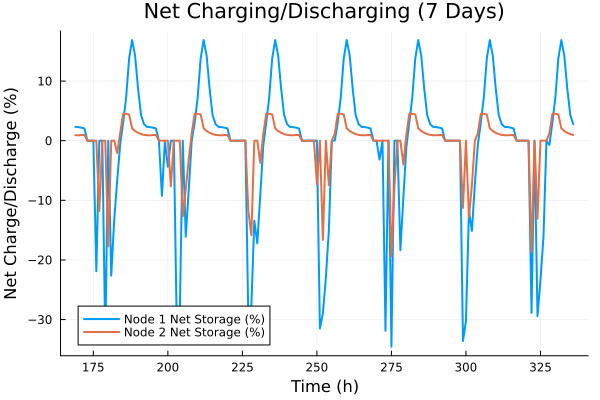

In [706]:
# --- 4. Plot Charging/Discharging (Centered at 0) in Percentage for 7 Days ---
pmax = filter(row -> row.Technology == stor_type, storage_node1).Pmax[1]

# Calculate net storage injection as (discharge - charge) and express it as a percentage of P_max.
net_storage_node1_pct = [100 * (value(discharge[1, stor_type, t]) - value(charge[1, stor_type, t])) / pmax for t in T_7days]
net_storage_node2_pct = [100 * (value(discharge[2, stor_type, t]) - value(charge[2, stor_type, t])) / pmax for t in T_7days]

plot(T_7days, net_storage_node1_pct,
     label="Node 1 Net Storage (%)",
     xlabel="Time (h)",
     ylabel="Net Charge/Discharge (%)",
     title="Net Charging/Discharging (7 Days)",
     lw=2)
plot!(T_7days, net_storage_node2_pct, label="Node 2 Net Storage (%)", lw=2)

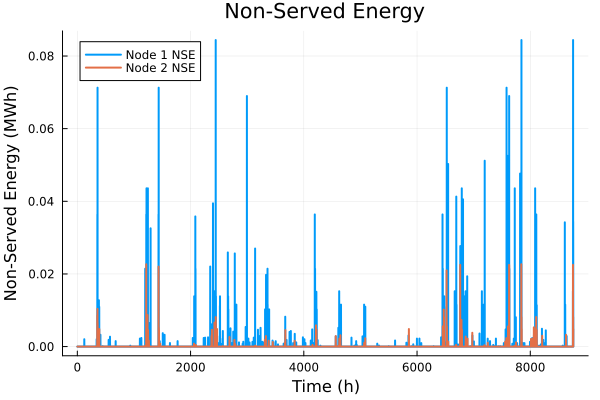

In [707]:
# 5. Plot Non-Served Energy (NSE)
# ================================
nse_node1 = [value(nse[1, t]) for t in T]
nse_node2 = [value(nse[2, t]) for t in T]

plot(T, nse_node1,
     label="Node 1 NSE",
     xlabel="Time (h)", ylabel="Non-Served Energy (MWh)",
     title="Non-Served Energy",
     lw=2)
plot!(T, nse_node2, label="Node 2 NSE", lw=2)

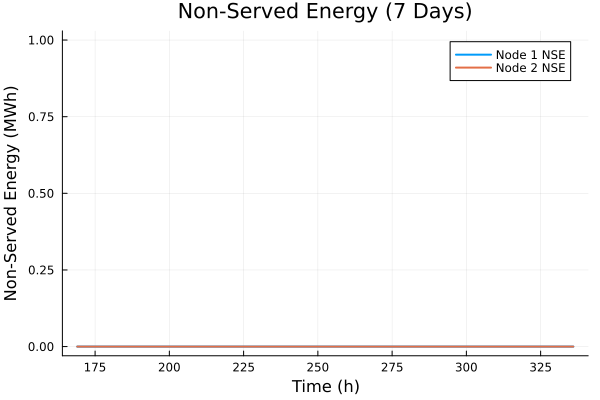

In [708]:
# --- 5. Plot Non-Served Energy (NSE) for 7 Days ---
nse_node1_7days = [value(nse[1, t]) for t in T_7days]
nse_node2_7days = [value(nse[2, t]) for t in T_7days]

plot(T_7days, nse_node1_7days,
     label="Node 1 NSE",
     xlabel="Time (h)", ylabel="Non-Served Energy (MWh)",
     title="Non-Served Energy (7 Days)",
     lw=2)
plot!(T_7days, nse_node2_7days, label="Node 2 NSE", lw=2)

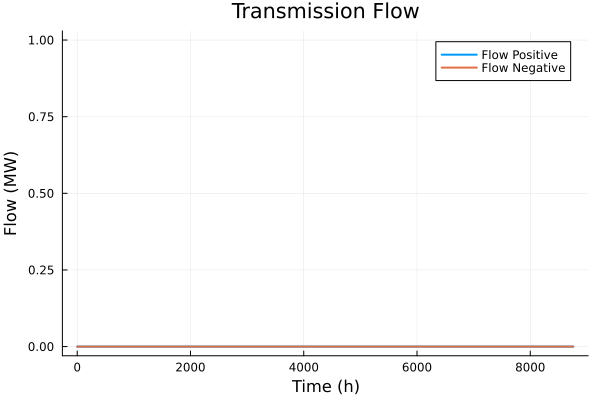

In [709]:
# 6. Plot Transmission Flow
# ==========================
# Here we plot the two flow components separately.
flow_positive = [value(flow_pos[t]) for t in T]
flow_negative = [value(flow_neg[t]) for t in T]

plot(T, flow_positive,
     label="Flow Positive",
     xlabel="Time (h)", ylabel="Flow (MW)",
     title="Transmission Flow",
     lw=2)
plot!(T, flow_negative, label="Flow Negative", lw=2)

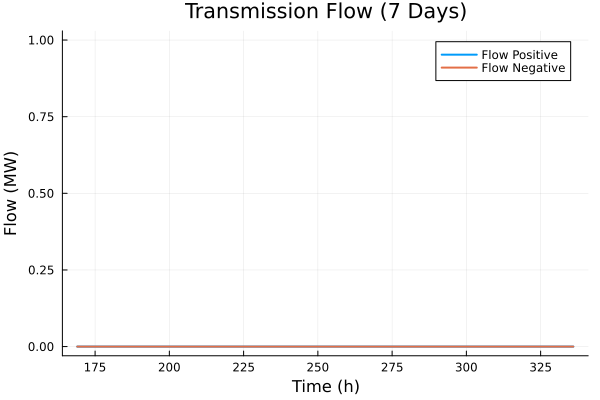

In [710]:
# --- 6. Plot Transmission Flow for 7 Days ---
flow_positive_7days = [value(flow_pos[t]) for t in T_7days]
flow_negative_7days = [value(flow_neg[t]) for t in T_7days]

plot(T_7days, flow_positive_7days,
     label="Flow Positive",
     xlabel="Time (h)", ylabel="Flow (MW)",
     title="Transmission Flow (7 Days)",
     lw=2)
plot!(T_7days, flow_negative_7days, label="Flow Negative", lw=2)

In [711]:
println("===== Optimization Results =====")

# 1. Display Solar Generation Capacity Built (MW)
println("\nSolar Capacity Built (MW):")
for i in nodes
    gen_capacity = value(solar_cap[i])
    println("  Node $i: $gen_capacity MW")
end

# 2. Display Battery (Storage) Capacity Built (MWh)
println("\nBattery Capacity Built (MWh):")
for i in nodes
    for s in STOR
        batt_capacity = value(storage_size[i, s])
        println("  Node $i ($s): $batt_capacity MWh")
    end
end

# 3. Display Total Cost of Not Serving (VoLL * NSE)
println("\nTotal Cost of Not Serving (VoLL * NSE):")
# Calculate for each node separately:
total_cost_nse_node1 = VoLL_node1 * sum(value(nse[1, t]) for t in T)
total_cost_nse_node2 = VoLL_node2 * sum(value(nse[2, t]) for t in T)
println("  Node 1: \$$(round(total_cost_nse_node1, digits=2))")
println("  Node 2: \$$(round(total_cost_nse_node2, digits=2))")

===== Optimization Results =====

Solar Capacity Built (MW):
  Node 1: 0.17441920028084965 MW
  Node 2: 0.11480584426229508 MW

Battery Capacity Built (MWh):
  Node 1 (BESS): 0.44366345000000007 MWh
  Node 2 (BESS): 0.14700451270491802 MWh

Total Cost of Not Serving (VoLL * NSE):
  Node 1: $47430.14
  Node 2: $25601.66


In [712]:
# Calculate total energy flow (MWh)
total_flow_pos = sum(value.(flow_pos[t]) for t in T)  # Total flow from Node 1 → Node 2
total_flow_neg = sum(value.(flow_neg[t]) for t in T)  # Total flow from Node 2 → Node 1
total_flow = total_flow_pos + total_flow_neg  # Total energy flow in both directions

# Calculate maximum possible energy flow (MWh)
max_possible_flow = trans_cap * 8760  # Transmission capacity * 8760 hours

# Calculate percentage utilization
percentage_utilization = (total_flow / max_possible_flow) * 100

# Print results
println("Total Energy Flow (Node 1 → Node 2): ", total_flow_pos, " MWh")
println("Total Energy Flow (Node 2 → Node 1): ", total_flow_neg, " MWh")
println("Total Energy Flow (Both Directions): ", total_flow, " MWh")
println("Maximum Possible Energy Flow: ", max_possible_flow, " MWh")
println("Percentage Utilization of Transmission Line: ", round(percentage_utilization, digits=2), "%")

Total Energy Flow (Node 1 → Node 2): 0.0 MWh
Total Energy Flow (Node 2 → Node 1): 0.0 MWh
Total Energy Flow (Both Directions): 0.0 MWh
Maximum Possible Energy Flow: 0.0 MWh
Percentage Utilization of Transmission Line: NaN%


In [713]:
# Calculate solar investment
solar_investment = sum(Fixed_Cost_Solar * value(solar_cap[i]) for i in nodes)

# Calculate battery investment
battery_investment = sum(Fixed_Cost_stor_node1 * value(storage_size[1, s]) for s in STOR) +
                     sum(Fixed_Cost_stor_node2 * value(storage_size[2, s]) for s in STOR)

# Calculate transmission investment
transmission_investment = Fixed_Cost_Trans 

# Calculate total investment
total_investment = solar_investment + battery_investment + transmission_investment

# Calculate for each node separately:
total_cost_nse_node1 = VoLL_node1 * sum(value(nse[1, t]) for t in T)
total_cost_nse_node2 = VoLL_node2 * sum(value(nse[2, t]) for t in T)
total_cost_nse = total_cost_nse_node1 + total_cost_nse_node2

overal_cost = total_investment + total_cost_nse

println("Solar Investment: \$$solar_investment")
println("Battery Investment: \$$battery_investment")
println("Transmission Investment: \$$transmission_investment")
println("Total Investment: \$$total_investment")
println("Total Operational Cost: \$$total_cost_nse")
println("Total Overall Cost: \$$overal_cost")



Solar Investment: $428469.2607629518
Battery Investment: $1.276096786666586e6
Transmission Investment: $0.0
Total Investment: $1.7045660474295379e6
Total Operational Cost: $73031.80385814517
Total Overall Cost: $1.777597851287683e6
